# Conditional RBM in Tensorflow 2.0

* Restricted Boltzmann Machinesfor Collaborative Filtering: https://www.cs.toronto.edu/~rsalakhu/papers/rbmcf.pdf
* Conditional Restricted Boltzmann Machines for Cold Start Recommendations: https://arxiv.org/pdf/1408.0096.pdf
* Conditional Restricted Boltzmann Machinesfor Structured Output Prediction: https://arxiv.org/pdf/1202.3748.pdf
* Item Category Aware Conditional RestrictedBoltzmann Machine Based Recommendation: http://or.nsfc.gov.cn/bitstream/00001903-5/422837/1/1000014232461.pdf
* User Occupation Aware Conditional RestrictedBoltzmann Machine Based Recommendation
* Factored Conditional Restricted Boltzmann Machinesfor Modeling Motion Style: https://www.cs.toronto.edu/~hinton/absps/fcrbm_icml.pdf

## Import tensorflow

In [18]:
%matplotlib inline
import matplotlib.pyplot as plt
plt.rcParams["figure.figsize"] = [10, 10]

import tensorflow as tf
import tensorflow_probability as tfp

from image_utils import tile_raster_images
from machine_learning.util.tf_utils import *

from tensorflow.keras.utils import to_categorical

## Define cool functions alias

* $\sigma$ as `tf.sigmoid`
* $X \sim Bernouli(k;p) = p^{k}(1-p)^{1-k} \text{ for } k \in \{0,1\}$
* `mean` as `tf.math.reduce_mean`
* $\sum$ as `tf.reduce_sum`
* `softplus` as `tf.summarnn.softplus` ($\text{soft}_{+}$)

In [2]:
σ = tf.sigmoid
bernoulli_sample = lambda p, samples=(): tfp.distributions.Bernoulli(probs=p).sample(samples).cast(tf.float32)
mean = tf.math.reduce_mean
Σ = tf.reduce_sum
softplus = tf.nn.softplus

## Define model parameters

**Note**: The vectors are _column vectors_

Hyperparameters:
* `hidden_size`: number of hidden units;
* `visible_size`: number of visible units. The element data input needs to be the same shape of the `visible_size`;
* `learning_rate`: ;
* `momentum`: ;
* `regualization`: ;
* `batch_size`: total of elements in a minibatch.

In [6]:
# Model hyperparameters
hidden_size = 500
visible_size = 28*28

# Learn hyperparameters
learning_rate = 0.1
momentum = 0.5
regularization = 0.01

batch_size = 100
epochs = 20

classes_size = 10  # 0 to 9

# Model parameters
W = tf.Variable(name='W', initial_value=0.01 * tf.random.normal([hidden_size, visible_size]), dtype=tf.float32)
D = tf.Variable(name='D', initial_value=0.01 * tf.random.normal([hidden_size, classes_size]), dtype=tf.float32)

b_h = tf.Variable(name='b_h', dtype=tf.float32, initial_value=tf.zeros([hidden_size, 1]))
b_v = tf.Variable(name='b_v', dtype=tf.float32, initial_value=tf.zeros([visible_size, 1]))

# Model parameters (learn)
ΔW = tf.Variable(name='dW', initial_value=tf.zeros([hidden_size, visible_size]), dtype=tf.float32)
ΔD = tf.Variable(name='dD', initial_value=tf.zeros([hidden_size, classes_size]), dtype=tf.float32)

Δb_v = tf.Variable(name='db_v', initial_value=tf.zeros([visible_size, 1]), dtype=tf.float32)
Δb_h = tf.Variable(name='db_h', initial_value=tf.zeros([hidden_size, 1]), dtype=tf.float32)

## Load dataset

In [7]:
import tensorflow_datasets as tfds

# Load dataset
dataset, info = tfds.load(name="mnist", split=tfds.Split.TRAIN, with_info=True)

In [8]:
import numpy as np
# Format data
def format_image(data):
    image = data['image']

    image = image.reshape((visible_size, ))  # To vector format compatible with rbm visible label
    image = image / 255                       # normalization
    image = (image > 0.5).cast(tf.float32)    # binarization
    
    data['image'] = image
    
    '''
    print(data['label'])
    print(data['label'].dtype)
    print(data['label'].to_vector())
    print(to_categorical([1, 2, 3, 0]))
    print(to_categorical(data['label'].reshape((1, ))))
    print(to_categorical(data['label'].to_vector()))
    '''
    return data

dataset = dataset.map(format_image)

In [9]:
# Build your input pipeline
dataset = dataset.repeat(epochs).shuffle(1024).batch(batch_size).prefetch(tf.data.experimental.AUTOTUNE)

In [10]:
# Assert that the visible layer has the correcly shape
image_shape = info.features['image'].shape
assert visible_size == image_shape[0]*image_shape[1]

## Energy function

There are many types of Conditional RBM. In this notebok, we use one type

$$E(\boldsymbol{v}, \boldsymbol{h}) = - \boldsymbol{h}^T\boldsymbol{W}\boldsymbol{v} - \boldsymbol{h}^T\boldsymbol{D}\boldsymbol{r}- \boldsymbol{v}^T\boldsymbol{b}^v - \boldsymbol{h}^T\boldsymbol{b}^h$$

In [11]:
def E(v, h, r):
    return - (h.T @ W @ v) - (h.T @ D @ r) - (v.T @ b_v) - (h.T @ b_h)

## Free energy function

$$F(\boldsymbol{v}, \boldsymbol{r}) = - \boldsymbol{v}^T\boldsymbol{b}^v - \sum_{i=1}^{K} soft_{+}(\boldsymbol{W}_{i\cdot} \boldsymbol{v} + \boldsymbol{D}_{i\cdot} \boldsymbol{r} + b_i^h)$$
$$F(\boldsymbol{v}, \boldsymbol{r}) = - \boldsymbol{v}^T\boldsymbol{b}^v - \sum \mathbf{soft}_{+}(\boldsymbol{W} \boldsymbol{v} + \boldsymbol{D} \boldsymbol{r} + \boldsymbol{b}^h)$$

Where:
* $\mathbf{soft}_{+}(\cdot)$: $soft_{+}(\cdot)$ element-wise

In [12]:
def F(v, r):
    return -(v.T @ b_v) - Σ(softplus(W @ v + D @ r + b_h), axis=0).to_vector()

## TODO - Conditional probabilities

* $P(h_i = 1|\boldsymbol{v}, \boldsymbol{r}) = \sigma(\boldsymbol{W}_{i \cdot} \boldsymbol{v} + \boldsymbol{D}_{i \cdot} \boldsymbol{r} + b^h_i)$
* $P(v_j=1|\boldsymbol{h}) = \sigma(\boldsymbol{h}^T \boldsymbol{W}_{\cdot j} + b^v_j)$
* $P(r_j=1|\boldsymbol{h}) = ?$

In [13]:
def P_h_given_v_r(v, r):
    return σ(W @ v + D @ r + b_h)

def P_v_given_h(h):
    return σ(h.T @ W + b_v.T).T

def P_r_given_h(h):
    return None

## Sampling

* $h_i^\text{next} \sim P(h_i = 1|\boldsymbol{v}, \boldsymbol{r})$
* $v_j^\text{next} \sim P(v_j=1|\boldsymbol{h}^\text{next})$

In [14]:
def gibbs_step(v0, r0):
    P_h0 = P_h_given_v_r(v0, r0)
    h0 = bernoulli_sample(p=P_h0)
    
    P_v1 = P_v_given_h(h0)
    v1 = bernoulli_sample(p=P_v1)

    return v1

## TODO - Learning

We will minimize the mean negative log likelihood for a dataset $\mathcal{D}$
$$f(\Theta, \mathcal{D}) = \frac{1}{N} \sum_{n=1}^N - \ln P(\boldsymbol{v}_n, \boldsymbol{r}_n)$$

The gradient of $f(\Theta, \mathcal{D})$
$$\frac{\nabla}{\nabla \theta} f(\Theta, \mathcal{D}) = \frac{1}{N} \nabla_\theta F(\boldsymbol{v}_n, \boldsymbol{r}_n) - ?.$$

For each parameter, the partial derivative are

* $\frac{\partial}{\partial w_{ij}} F(\boldsymbol{v}, \boldsymbol{r}) = P(h_i=1|\boldsymbol{v}, \boldsymbol{r}) v_j $
* $\frac{\partial}{\partial d_{ij}} F(\boldsymbol{v}, \boldsymbol{r}) = P(h_i=1|\boldsymbol{v}, \boldsymbol{r}) r_j $
* $\frac{\partial}{\partial b^h_{i}} F(\boldsymbol{v}, \boldsymbol{r}) = P(h_i=1|\boldsymbol{v}, \boldsymbol{r}) $
* $\frac{\partial}{\partial b^v_{j}} F(\boldsymbol{v}, \boldsymbol{r}) = b^v_j $



In [15]:
η = learning_rate
α = momentum
λ = regularization

for i, features in enumerate(dataset):
    image, label = features["image"], features["label"]

    v0 = image.T
    r0 = to_categorical(label, classes_size).T

    with tf.name_scope('gibbs_chain'):
        P_h0_given_v0_r0 = P_h_given_v_r(v0, r0)
        h0 = bernoulli_sample(p=P_h0_given_v0_r0)

        P_v1_given_h0 = P_v_given_h(h0)
        v1 = bernoulli_sample(p=P_v1_given_h0)
        
        #P_r1_given_h0 = P_r_given_h(h0)
        #r1 = bernoulli_sample(p=P_r1_given_h0)

        #P_h1_given_v1_r1 = P_h_given_v(v1, r1)
        #h1 = bernoulli_sample(p=P_h1_given_v1_r1)
        P_h1_given_v1_r0 = P_h_given_v_r(v1, r0)
        h1 = bernoulli_sample(p=P_h1_given_v1_r0)

    #Δparam = η * mean(gradent(param)) - mean(gradent(param_0)) - η*λ*param + α*Δparam

    with tf.name_scope('delta_W'):
        #ΔW = η * (P_h0_given_v0_r0 @ v0.T - P_h1_given_v1_r1 @ v1.T) - λ*W + α*ΔW
        ΔW = η * (P_h0_given_v0_r0 @ v0.T - P_h1_given_v1_r0 @ v1.T)/batch_size - η*λ*W + α*ΔW

    # Wrong
    #with tf.name_scope('delta_D'):
        ##ΔD = η * (P_h0_given_v0_r0 @ v0.T - P_h1_given_v1_r1 @ v0.T) - λ*D + α*ΔD
    #    ΔD = η * (P_h0_given_v0_r0 @ v0.T - P_h1_given_v1_r0 @ v1.T) - λ*D + α*ΔD

    with tf.name_scope('delta_v_b'):
        Δb_v = η * mean(v0 - v1, axis=1).to_vector() + α*Δb_v

    with tf.name_scope('delta_h_b'):
        #Δb_h = η * mean(P_h0_given_v0_r0 - P_h1_given_v1_r1, axis=1).to_vector() + α*Δb_h
        Δb_h = η * mean(P_h0_given_v0_r0 - P_h1_given_v1_r0, axis=1).to_vector() + α*Δb_h


    W = W + ΔW
    D = D + ΔD
    b_v = b_v + Δb_v
    b_h = b_h + Δb_h
    
    if i%(500) == 0:
        with tf.name_scope('summaries'):
            print('Step', i, mean(F(v0, r0)))
            #tf.summary.scalar('FreeEnergy', mean(F(v0, r0)))

print('Step', i, mean(F(v0)))

Step 0 tf.Tensor(-191.15625, shape=(), dtype=float32)
Step 500 tf.Tensor(-348.2335, shape=(), dtype=float32)
Step 1000 tf.Tensor(-424.1977, shape=(), dtype=float32)
Step 1500 tf.Tensor(-452.03876, shape=(), dtype=float32)
Step 2000 tf.Tensor(-464.88318, shape=(), dtype=float32)
Step 2500 tf.Tensor(-478.72824, shape=(), dtype=float32)
Step 3000 tf.Tensor(-490.7229, shape=(), dtype=float32)
Step 3500 tf.Tensor(-495.45016, shape=(), dtype=float32)
Step 4000 tf.Tensor(-498.85013, shape=(), dtype=float32)
Step 4500 tf.Tensor(-496.8767, shape=(), dtype=float32)
Step 5000 tf.Tensor(-500.79718, shape=(), dtype=float32)
Step 5500 tf.Tensor(-500.66565, shape=(), dtype=float32)
Step 6000 tf.Tensor(-492.95544, shape=(), dtype=float32)
Step 6500 tf.Tensor(-508.3449, shape=(), dtype=float32)
Step 7000 tf.Tensor(-497.4281, shape=(), dtype=float32)
Step 7500 tf.Tensor(-494.09366, shape=(), dtype=float32)
Step 8000 tf.Tensor(-498.78827, shape=(), dtype=float32)
Step 8500 tf.Tensor(-495.2722, shape=(), 

In [16]:
%tensorboard --logdir logs

UsageError: Line magic function `%tensorboard` not found.


## TODO - Plots

### Weights

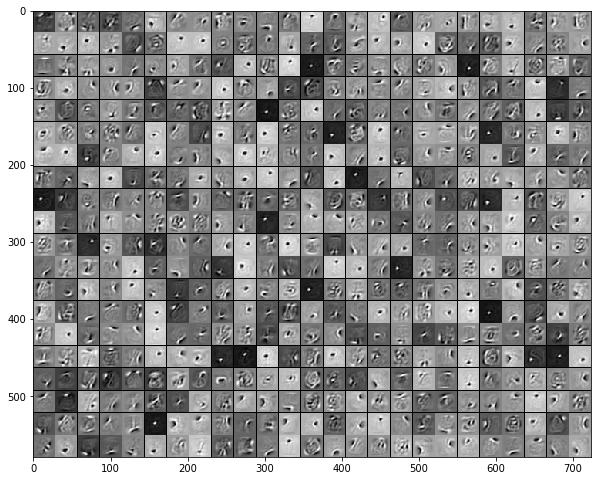

In [20]:
plt.imshow(tile_raster_images(
    X=W.numpy(),
    img_shape=(28, 28),
    tile_shape=(20, 25),
    tile_spacing=(1, 1),
), cmap='gray')

### Input

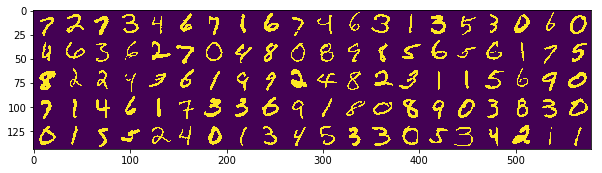

In [21]:
plt.imshow(tile_raster_images(
    X=image.numpy(),
    img_shape=(28, 28),
    tile_shape=(5, 20),
    tile_spacing=(1, 1)
))

### Probability

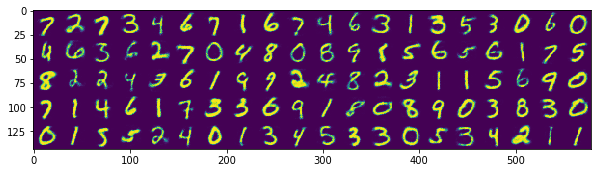

In [22]:
image_probability = P_v_given_h(P_h_given_v_r(v0, r0))

plt.imshow(tile_raster_images(
    X=image_probability.T.numpy(),
    img_shape=(28, 28),
    tile_shape=(5, 20),
    tile_spacing=(1, 1)
))

### Sampled

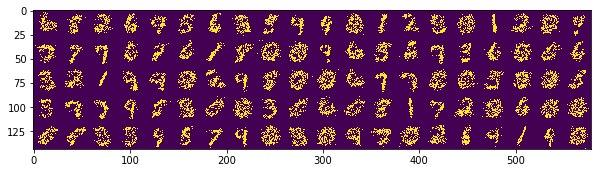

In [93]:
image_reconstructed = gibbs_step(v0, r0)

plt.imshow(tile_raster_images(
    X=image_reconstructed.T.numpy(),
    img_shape=(28, 28),
    tile_shape=(5, 20),
    tile_spacing=(1, 1)
))

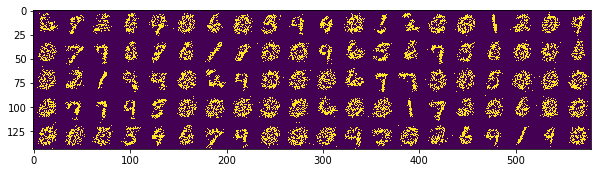

In [95]:
image_reconstructed = v0
for i in range(1000):
    image_reconstructed = gibbs_step(image_reconstructed, r0)

plt.imshow(tile_raster_images(
    X=image_reconstructed.T.numpy(),
    img_shape=(28, 28),
    tile_shape=(5, 20),
    tile_spacing=(1, 1)
)) 

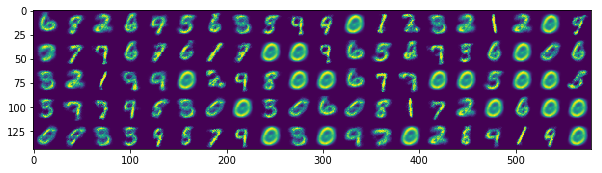

In [117]:
import numpy as np

r_fake = np.array([[0, 0, 0, 0, 0, 0, 0, 0, 0, 1]] * r0.shape[1]).T
image_probability2 = P_v_given_h(P_h_given_v_r(v0, r_fake))

plt.imshow(tile_raster_images(
    X=image_probability.T.numpy(),
    img_shape=(28, 28),
    tile_shape=(5, 20),
    tile_spacing=(1, 1)
))